<a href="https://colab.research.google.com/github/alixintong/btt-ai-know-your-customer/blob/main/pix2seq_finetuning_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title License
# Copyright 2022 The Pix2Seq Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## Pix2seq: A Language Modeling Framework for Object Detection
<a href="https://colab.research.google.com/github/google-research/pix2seq/blob/master/colabs/pix2seq_finetuning_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This colab presents a demo for object detection fine-tuning with Pix2seq. The table below provides a summary and model location for pretrained models on Objects365 dataset, which can be used as initializations for fine-tuning.

Backbone       | Total params (M) | Image size | Google cloud storage location
-------------: | ---------------: | ---------: | -----------:
ResNet-50      | 36.6             | 640x640    | [gs://pix2seq/obj365_pretrain/resnet_640x640_b256_s400k](https://console.cloud.google.com/storage/browser/pix2seq/obj365_pretrain/resnet_640x640_b256_s400k)
ResNet-50 (C4) | 84.7             | 640x640    | [gs://pix2seq/obj365_pretrain/resnetc_640x640_b256_s400k](https://console.cloud.google.com/storage/browser/pix2seq/obj365_pretrain/resnetc_640x640_b256_s400k)
ViT-L          | 115.2            | 640x640    | [gs://pix2seq/obj365_pretrain/vit_b_640x640_b256_s400k](https://console.cloud.google.com/storage/browser/pix2seq/obj365_pretrain/vit_b_640x640_b256_s400k)
ViT-B          | 341.2            | 640x640    | [gs://pix2seq/obj365_pretrain/vit_l_640x640_b256_s400k](https://console.cloud.google.com/storage/browser/pix2seq/obj365_pretrain/vit_l_640x640_b256_s400k)


In [ ]:
# pip installs.
!pip install ml_collections
!pip install tensorflow-addons
!git clone https://github.com/google/pix2seq.git

import os, sys

sys.path.append(os.getcwd())
root_dir = os.getcwd()
sys.path.insert(1, 'pix2seq')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 6.0 MB/s 
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94524 sha256=b7a2aeaab4cbee84ce78570f57a0fa63fa9f7e1eeab82fc914df900032237b1b
  Stored in directory: /root/.cache/pip/wheels/b7/da/64/33c926a1b10ff19791081b705879561b715a8341a856a3bbd2
Successfully built ml-collections
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 11.5 MB/s 
Cloning into 'pix2seq'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 137 (delta 23), reused 18 (delta 18), pack-reused 108
Receiving objects: 100% (137/137), 14.29 MiB | 8.80 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [ ]:
# Imports.
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import requests
import json

import ml_collections
import utils
from data.dataset import Dataset
from models import model as model_lib
from models import ar_model
from tasks import task as task_lib
from tasks import object_detection

In [ ]:
# Define a Dataset class to use for finetuning.
class VocDataset(Dataset):

  def extract(self, example, training):
    """Extracts needed features & annotations into a flat dictionary.

    Note: be consisous about 0 in label, which should probably reserved for
       special use (such as padding).

    Args:
      example: `dict` of raw features.
      training: `bool` of training vs eval mode.

    Returns:
      example: `dict` of relevant features and labels
    """
    # These features are needed by the object detection task.
    features = {
        'image': tf.image.convert_image_dtype(example['image'], tf.float32),
        'image/id': 0, # dummy int.
    }

    # The following labels are needed by the object detection task.
    label = example['objects']['label'] + 1  # 0 is reserved for padding.
    bbox = example['objects']['bbox']

    # Use tf.numpy_function to get features not easily computed in tf.
    def get_area(bboxes):
      return np.asarray([
          (b[2] - b[0]) * (b[3] - b[1]) for b in bboxes], dtype=np.int32)

    areas = tf.numpy_function(get_area, (bbox,), (tf.int32,))
    areas = tf.reshape(areas, [tf.shape(label)[0]])

    labels = {
        'label': label,
        'bbox': bbox,
        'area': areas,
        'is_crowd': tf.zeros_like(label, tf.bool),
    }
    return features, labels

In [ ]:
# Load config for the pretrained model.
pretrained_model_dir = 'gs://pix2seq/obj365_pretrain/resnet_640x640_b256_s400k/'
with tf.io.gfile.GFile(os.path.join(pretrained_model_dir, 'config.json'), 'r') as f:
  config = ml_collections.ConfigDict(json.loads(f.read()))

# Update config for finetuning (some configs were missing at initial pretraining time).
config.dataset.tfds_name = 'voc'
config.dataset.batch_duplicates = 1
config.dataset.coco_annotations_dir = None
config.task.name == 'object_detection'
config.task.vocab_id = 10  # object_detection task vocab id.
config.task.weight = 1.
config.task.max_instances_per_image_test = 10
config.tasks = [config.task]
config.train.batch_size = 8
config.model.name = 'encoder_ar_decoder'  # name of model and trainer in registries.
config.model.pretrained_ckpt = pretrained_model_dir
config.optimization.learning_rate = 1e-4
config.optimization.warmup_steps = 10

# Use a smaller image_size to speed up finetuning here.
# You can use any image_size of choice.
config.model.image_size = 320
config.task.image_size = 320

In [ ]:
# Perform training for 1000 steps. This takes about ~20 minutes on a regular Colab GPU.
train_steps = 1000
use_tpu = False  # Set this accordingly.
steps_per_loop = 10
tf.config.run_functions_eagerly(False)

strategy = utils.build_strategy(use_tpu=use_tpu, master='')

# The following snippets are mostly copied and simplified from run.py.
with strategy.scope():
  # Get dataset.
  dataset = VocDataset(config)

  # Get task.
  task = task_lib.TaskRegistry.lookup(config.task.name)(config)
  tasks = [task]

  # Create tf.data.Dataset.
  ds = dataset.pipeline(
      process_single_example=task.preprocess_single,
      global_batch_size=config.train.batch_size,
      training=True)
  datasets = [ds]
  
  # Setup training elements.
  trainer = model_lib.TrainerRegistry.lookup(config.model.name)(
      config, model_dir='model_dir',
      num_train_examples=dataset.num_train_examples, train_steps=train_steps)
  data_iterators = [iter(dataset) for dataset in datasets]

  @tf.function
  def train_multiple_steps(data_iterators, tasks):
    train_step = lambda xs, ts=tasks: trainer.train_step(xs, ts, strategy)
    for _ in tf.range(steps_per_loop):  # using tf.range prevents unroll.
      with tf.name_scope(''):  # prevent `while_` prefix for variable names.
        strategy.run(train_step, ([next(it) for it in data_iterators],))

  global_step = trainer.optimizer.iterations
  cur_step = global_step.numpy()
  while cur_step < train_steps:
    train_multiple_steps(data_iterators, tasks)
    cur_step = global_step.numpy()
    print(f"Done training {cur_step} steps.")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/4952 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/voc/2007/4.0.0.incomplete2T3I93/voc-test.tfrecord*...:   0%|          | 0/4952…

Generating train examples...:   0%|          | 0/2501 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/voc/2007/4.0.0.incomplete2T3I93/voc-train.tfrecord*...:   0%|          | 0/250…

Generating validation examples...:   0%|          | 0/2510 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/voc/2007/4.0.0.incomplete2T3I93/voc-validation.tfrecord*...:   0%|          | …

Dataset voc downloaded and prepared to ~/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.
Done training 10 steps.
Done training 20 steps.
Done training 30 steps.
Done training 40 steps.
Done training 50 steps.
Done training 60 steps.
Done training 70 steps.
Done training 80 steps.
Done training 90 steps.
Done training 100 steps.
Done training 110 steps.
Done training 120 steps.
Done training 130 steps.
Done training 140 steps.
Done training 150 steps.
Done training 160 steps.
Done training 170 steps.
Done training 180 steps.
Done training 190 steps.
Done training 200 steps.
Done training 210 steps.
Done training 220 steps.
Done training 230 steps.
Done training 240 steps.
Done training 250 steps.
Done training 260 steps.
Done training 270 steps.
Done training 280 steps.
Done training 290 steps.
Done training 300 steps.
Done training 310 steps.
Done training 320 steps.
Done training 330 steps.
Done training 340 steps.
Done training 350 steps.
Done training 360 

In [ ]:
# Run one step of inference (on the training set).

# Set category names in task for visualization.
# The category names for COCO are picked up from the coco annotation files. For
# other datasets, they can be added manually in the code. If they are missing,
# the visualization will not contain category names for predicted boxes, but
# no other things will be impacted.
category_names = [
    'Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle', 'Bus', 'Car', 'Cat',
    'Chair', 'Cow', 'Dining table', 'Dog', 'Horse', 'Motorbike', 'People',
    'Potted plant', 'Sheep', 'Sofa', 'Train', 'TV/monitor']
task._category_names = {
    i + 1 : {'name': name} for i, name in enumerate(category_names)}

def single_step(examples):
  preprocessed_outputs = task.preprocess_batched(examples, training=False)
  infer_outputs = task.infer(trainer.model, preprocessed_outputs)
  return task.postprocess_tpu(*infer_outputs)

with strategy.scope():
  @tf.function
  def run_single_step(iterator):
    examples = next(iterator)
    outputs = strategy.run(single_step, (examples,))
    if outputs is not None:
      outputs = [strategy.gather(t, axis=0) for t in outputs]
    return outputs

  iterator = iter(ds)
  per_step_outputs = run_single_step(iterator)
  vis = task.postprocess_cpu(
      per_step_outputs,
      train_step=100,
      eval_step=0,
      ret_results=True)

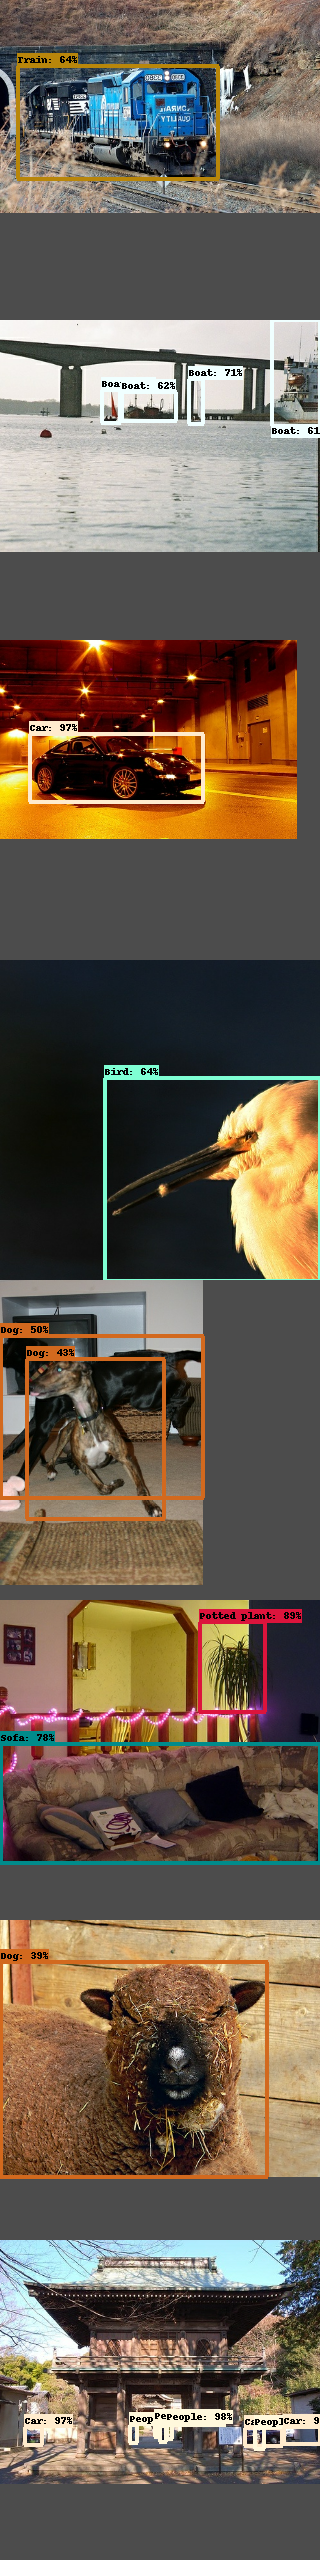

In [ ]:
# Visualization.
im = tf.concat([vis['pred'][i] for i in range(config.train.batch_size)], 0)
Image.fromarray(np.uint8(im.numpy() * 255))

# Hard Dataset 
- zoomed out, scaled, rotated, etc.

##Approach 1: draw a polygon

In [ ]:
width = 1920
height = 1080

# create a white blank image
img = Image.new('RGB', size=(width, height), color='blue') 

# draw a rotated 620*680 rectangle inside 
draw = ImageDraw.Draw(img)
alpha = 60
rec_coord = [(500, 300), (math.sin(alpha)*620+500, abs(math.cos(alpha))*620+300),
             (500-math.sin(90-alpha)*680+math.sin(alpha)*620, math.cos(90-alpha)*680+300-math.cos(alpha)*620), (500-math.sin(90-alpha)*680, math.cos(90-alpha)*680+300)] # 620*680
print(rec_coord)
draw.polygon((rec_coord[0], rec_coord[1],
              rec_coord[2], rec_coord[3]), fill ="#ffff33") # draw a yellow rectangle with blue background

[(500, 300), (311.0174149166256, 890.4960478573969), (982.8789192997716, 995.387033780954), (1171.861504383146, 404.89098592355714)]


In [ ]:
img

## Approach 2: Paste the rectangle onto the image & Rotate it
- need to recalculate the coordinates after rotating & pasting

### rotating the image

In [ ]:
width = 1920
height = 1080

# create a white blank image
img1 = Image.new('RGB', size=(width, height), color='blue') 

# draw a rotated 620*680 rectangle inside 
img2 = Image.new('RGB', size=(620, 680), color='blue') 
draw = ImageDraw.Draw(img2)
rec_coord = [(0,0),(620, 680)]
draw.rectangle(rec_coord, fill ="#ffff33")

In [ ]:
rot_im = img2.rotate(45, expand=False, fillcolor="blue")
img1.paste(rot_im, (500, 300))

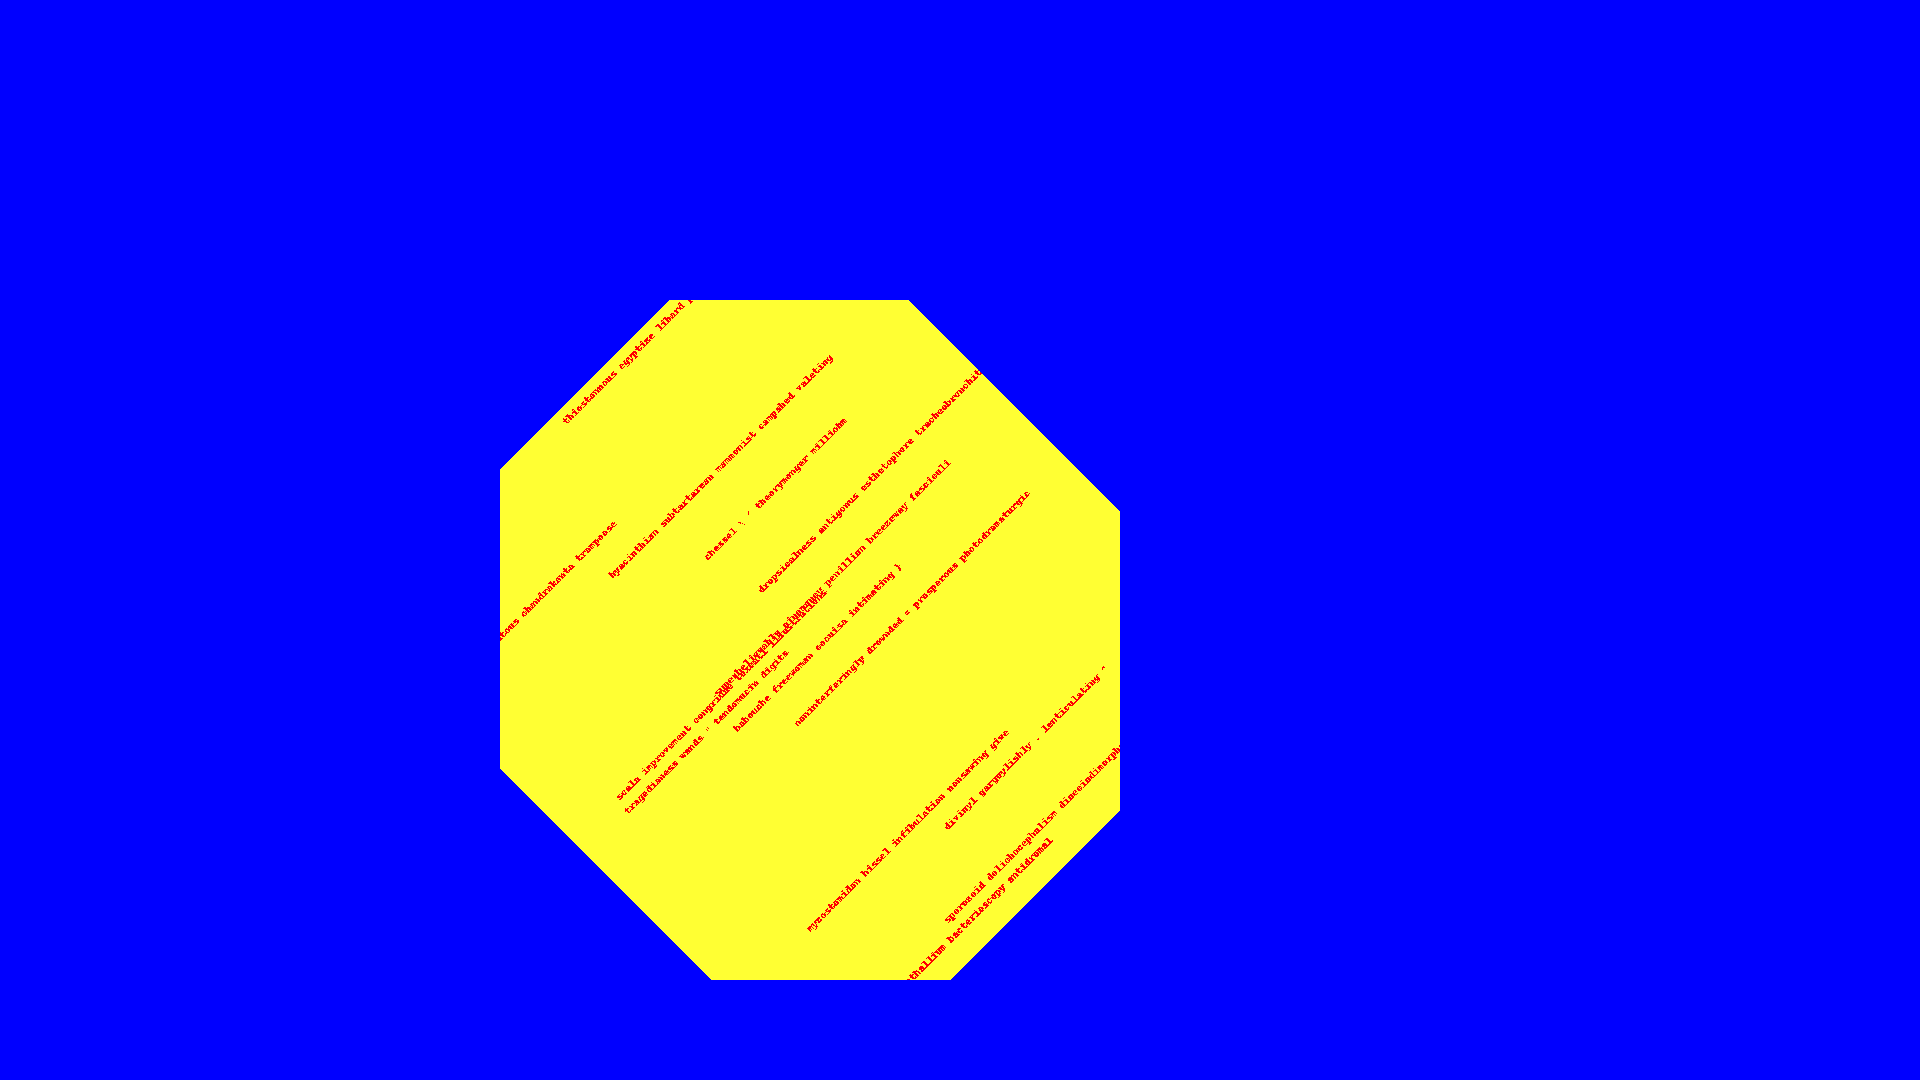

In [ ]:
img1

### Directly draw on the rectangle

In [ ]:
# this cell allows access to our folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip3 install random-word pyyaml

In [ ]:
import random 
from PIL import Image, ImageDraw, ImageFont
import matplotlib
import string
from random_word import RandomWords
import math
import pandas as pd

In [ ]:
# a function to calculate the text size
def get_text_dimensions(text_string, font):
    # https://levelup.gitconnected.com/how-to-properly-calculate-text-size-in-pil-images-17a2cc6f51fd
    # https://stackoverflow.com/a/46220683/9263761
    ascent, descent = font.getmetrics()

    text_width = font.getmask(text_string).getbbox()[2]
    text_height = font.getmask(text_string).getbbox()[3] + descent

    return (text_width, text_height)

In [ ]:
def valid_text_coordinates(x, y, x1, y1, x2, y2):
  end_x = x + text_width
  end_y = x + text_height

  # NO NEED FOR THIS CASE (since we directly draw text on the rectangle)
  # check if the text is outside the rectangle 
  # e.g. rec_coord = [(0,0),(620, 680)]
  # if x < rec_coord[0][0] | x > rec_coord[1][0] | y < rec_coord[0][1] | y > rec_coord[1][1]):
  #   return False

  # check if the text is overlapped with previously added text
  for i in range(0, len(coord_list)):
    if (x >= x1[i] & x <= x2[i] & y <= y1[i] & y >= y2[i]) or (end_x>=x1[i] & end_x<=x2[i] & end_y <= y1[i] & end_y >= y2[i]):
      return False
  return True

In [ ]:
# wrap the image generation into a function
def generate_imgs(num_of_img):
  width = 1920
  height = 1080

  punc_list = list(string.punctuation) # a list of punctuation marks in English
  random_words = RandomWords()

  for i in range(0, num_of_img):
    # create a white blank image
    img1 = Image.new('RGB', size=(width, height), color='blue') 

    # draw a rotated 620*680 rectangle inside 
    img2 = Image.new('RGB', size=(620, 680), color='blue') 
    draw = ImageDraw.Draw(img2)
    rec_coord = [(0,0),(620, 680)]
    draw.rectangle(rec_coord, fill ="#ffff33")

    # randomly generate 50 words
    str_list = []
    for number in range(0, 10): 
      str_list.append(random_words.get_random_word()) 

    # randomly insert 8 punctuation marks into the list
    punc_to_insert = random.sample(punc_list, 8)
    for punc in punc_to_insert:
      str_list.insert(random.randint(0, len(str_list)), punc)

    # randomly divide the word list into chunks of size 5
    chunk_size = 5
    chunked_list = [str_list[j:j+chunk_size] for j in range(0, len(str_list), chunk_size)]

    coord_list = [] # list to store starting & ending coordinates x1, y1, x2, y2
    text_list = [] # list to store texts 

    # list to store fonts and sizes to randomize later
    fonts = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
    sizes = range(11, 15) 

    for chunk in chunked_list:
      # calculate the text size
      text = ' '.join(chunk)
      font = ImageFont.truetype(random.sample(fonts,1)[0], size=random.sample(sizes, 1)[0])
      text_width, text_height = get_text_dimensions(text, font)

      # get starting & ending coordinates
      start_coord = [] # x1, y1 (upper-left)

      x = random.randint(rec_coord[0][0]+5, rec_coord[1][0]-200)
      y = random.randint(rec_coord[0][1]+5, rec_coord[1][1]-20)

      # rec_coord = [(0,0),(620, 680)]
      if (coord_list):
        x1 = [coord[0] for coord in coord_list]
        y1 = [coord[1] for coord in coord_list]
        x2 = [coord[2] for coord in coord_list]
        y2 = [coord[3] for coord in coord_list]
        while not valid_text_coordinates(x, y, x1, y1, x2, y2):
          x = random.randint(rec_coord[0][0]+5, rec_coord[1][0]-200)
          y = random.randint(rec_coord[0][1]+5, rec_coord[1][1]-20)
      start_coord.append(x)
      start_coord.append(y)

      # draw the text on the rectangle
      draw.text(start_coord, text, fill = 'red', font = font) 

      end_coord = [start_coord[0]+text_width, start_coord[1]+text_height] # x2, y2 (bottom-right)

      # store the coordinates and text 
      coord_list.append([start_coord[0], start_coord[1], end_coord[0], end_coord[1]])
      text_list.append(text)

    # save the generated image to google drive
    img2.save('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/generatedDataset/experiment_dataset/'+ 'img' + str(i) + '.jpg')
    print("image successfully saved!")

  x1 = [coord[0] for coord in coord_list]
  y1 = [coord[1] for coord in coord_list]
  x2 = [coord[2] for coord in coord_list]
  y2 = [coord[3] for coord in coord_list]

  # make a dataframe as the label
  label = pd.DataFrame(
      {'x1': x1,
      'y1': y1,
      'x2': x2,
      'y2': y2,
      'text': text_list
      })

  label.to_csv('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/generatedDataset/experiment_dataset/label.csv')
  print("label successfully saved!")

  return label

In [ ]:
generate_imgs(3)

image successfully saved!
image successfully saved!
image successfully saved!
label successfully saved!


,x1,y1,x2,y2,text
0,135,578,277,593,"newmanite , ; insolvency }"
1,215,117,446,132,slickness ^ concubinaries ! epicurize
2,342,277,692,292,homocercal conflictingly goyin tartrates vacua...
3,346,243,374,258,% @ :


### Draw with background

In [ ]:
# this cell allows access to our folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip3 install random-word pyyaml

In [ ]:
import random 
from PIL import Image, ImageDraw, ImageFont
import matplotlib
import string
from random_word import RandomWords
import math
import pandas as pd

In [ ]:
# a function to calculate the text size
def get_text_dimensions(text_string, font):
    # https://levelup.gitconnected.com/how-to-properly-calculate-text-size-in-pil-images-17a2cc6f51fd
    # https://stackoverflow.com/a/46220683/9263761
    ascent, descent = font.getmetrics()

    text_width = font.getmask(text_string).getbbox()[2]
    text_height = font.getmask(text_string).getbbox()[3] + descent

    return (text_width, text_height)

In [ ]:
def valid_text_coordinates(x, y, x1, y1, x2, y2, rec_coord):
  end_x = x + text_width
  end_y = x + text_height

  # check if the text is outside the rectangle 
  # e.g. rec_coord = [(0,0),(620, 680)]
  if (x < rec_coord[0][0] | x > rec_coord[1][0] | y < rec_coord[0][1] | y > rec_coord[1][1]) or (end_x <= rec_coord[0][0] | end_x > rec_coord[1][0] | end_y < rec_coord[0][1] | end_y > rec_coord[1][1]):
    return False

  # check if the text is overlapped with previously added text
  for i in range(0, len(coord_list)):
    if (x >= x1[i] & x <= x2[i] & y <= y1[i] & y >= y2[i]) or (end_x>=x1[i] & end_x<=x2[i] & end_y <= y1[i] & end_y >= y2[i]):
      return False
  return True

In [ ]:
# wrap the image generation into a function
def generate_imgs(num_of_img):
  width = 1920
  height = 1080

  punc_list = list(string.punctuation) # a list of punctuation marks in English
  random_words = RandomWords()

  for i in range(0, num_of_img):
    # create a white blank image
    img1 = Image.new('RGB', size=(width, height), color='blue') 

    # draw a rotated 620*680 rectangle inside 
    draw = ImageDraw.Draw(img1)
    rec_coord = [(500, 300), (width - 800, height - 100)] # 620*680
    draw.rectangle(rec_coord, fill ="#ffff33")

    # randomly generate 50 words
    str_list = []
    for number in range(0, 10): 
      str_list.append(random_words.get_random_word()) 

    # randomly insert 8 punctuation marks into the list
    punc_to_insert = random.sample(punc_list, 8)
    for punc in punc_to_insert:
      str_list.insert(random.randint(0, len(str_list)), punc)

    # randomly divide the word list into chunks of size 5
    chunk_size = 5
    chunked_list = [str_list[j:j+chunk_size] for j in range(0, len(str_list), chunk_size)]

    coord_list = [] # list to store starting & ending coordinates x1, y1, x2, y2
    text_list = [] # list to store texts 

    # list to store fonts and sizes to randomize later
    fonts = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
    sizes = range(11, 15) 

    for chunk in chunked_list:
      # calculate the text size
      text = ' '.join(chunk)
      font = ImageFont.truetype(random.sample(fonts,1)[0], size=random.sample(sizes, 1)[0])
      text_width, text_height = get_text_dimensions(text, font)

      # get starting & ending coordinates
      start_coord = [] # x1, y1 (upper-left)

      x = random.randint(rec_coord[0][0]+5, rec_coord[1][0]-200)
      y = random.randint(rec_coord[0][1]+5, rec_coord[1][1]-20)

      # rec_coord = [(0,0),(620, 680)]
      if (coord_list):
        x1 = [coord[0] for coord in coord_list]
        y1 = [coord[1] for coord in coord_list]
        x2 = [coord[2] for coord in coord_list]
        y2 = [coord[3] for coord in coord_list]
        while not valid_text_coordinates(x, y, x1, y1, x2, y2, rec_coord):
          x = random.randint(rec_coord[0][0]+5, rec_coord[1][0]-200)
          y = random.randint(rec_coord[0][1]+5, rec_coord[1][1]-20)
      start_coord.append(x)
      start_coord.append(y)

      # draw the text on the rectangle
      draw.text(start_coord, text, fill = 'red', font = font) 

      end_coord = [start_coord[0]+text_width, start_coord[1]+text_height] # x2, y2 (bottom-right)

      # store the coordinates and text 
      coord_list.append([start_coord[0], start_coord[1], end_coord[0], end_coord[1]])
      text_list.append(text)

    # save the generated image to google drive
    img1.save('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/generatedDataset/experiment_dataset/'+ 'img' + str(i) + '.jpg')
    print("image successfully saved!")

  x1 = [coord[0] for coord in coord_list]
  y1 = [coord[1] for coord in coord_list]
  x2 = [coord[2] for coord in coord_list]
  y2 = [coord[3] for coord in coord_list]

  # make a dataframe as the label
  label = pd.DataFrame(
      {'x1': x1,
      'y1': y1,
      'x2': x2,
      'y2': y2,
      'text': text_list
      })

  label.to_csv('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/generatedDataset/experiment_dataset/label.csv')
  print("label successfully saved!")

  return label

In [ ]:
generate_imgs(3)

image successfully saved!
image successfully saved!
image successfully saved!
label successfully saved!


,x1,y1,x2,y2,text
0,753,329,955,342,nondispersion sateless } feeblemindedness `
1,712,411,892,423,. ! < cosmochemical cardstock
2,838,666,1028,680,"uncancellable deputy % haystack """
3,792,345,896,356,belucki + zonaesthesia
